In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [2]:
plt.style.use('ggplot')

## Build ResNet

In [3]:
# Basic Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Adjusting dimensions if needed
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

# ResNet-32 Model
class ResNet32(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet32, self).__init__()
        self.in_channels = 16  # Assuming the same initial number of channels as LeNet-3

        # Initial convolution
        self.conv = nn.Conv2d(1, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)

        # Stacking residual blocks
        self.layer1 = self.make_layer(ResidualBlock, 16, 2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 32, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 64, 2, stride=2)

        # Global average pooling
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels  # Update in_channels for the next iteration
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

In [4]:
# Define transformations and create dataset
transform = transforms.Compose([transforms.Grayscale(), # Convert to grayscale
                                transforms.Resize((320, 320)), # Resize to LeNet input size
                                transforms.RandomRotation(10), # Randomly rotate the image up to 10 degrees
                                transforms.ToTensor()])

train_dataset = ImageFolder(root="./images/train", transform=transform)
test_dataset = ImageFolder(root="./images/test", transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Train Data

In [5]:
# Initialize the model, loss function, and optimizer
model = ResNet32().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Training loop with accuracy tracking
num_epochs = 200
accuracies = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    accuracies.append(accuracy)


    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

# Test the model
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on valid set: {accuracy * 100:.2f}%")

Epoch 1/200, Loss: 1.0109657049179077
Epoch 2/200, Loss: 0.7366800308227539
Epoch 3/200, Loss: 0.7669716477394104
Epoch 4/200, Loss: 0.7695764899253845
Epoch 5/200, Loss: 0.7845821380615234
Epoch 6/200, Loss: 0.991858959197998
Epoch 7/200, Loss: 0.5960900783538818
Epoch 8/200, Loss: 0.5679087042808533
Epoch 9/200, Loss: 0.7818251252174377
Epoch 10/200, Loss: 0.8338205814361572
Epoch 11/200, Loss: 0.6814586520195007
Epoch 12/200, Loss: 0.6239060163497925
Epoch 13/200, Loss: 0.42763450741767883
Epoch 14/200, Loss: 0.8136019110679626
Epoch 15/200, Loss: 0.7058098316192627
Epoch 16/200, Loss: 0.4801398813724518
Epoch 17/200, Loss: 0.6939290165901184
Epoch 18/200, Loss: 0.5735439658164978
Epoch 19/200, Loss: 0.6376072764396667
Epoch 20/200, Loss: 0.4561404883861542
Epoch 21/200, Loss: 0.5761197209358215
Epoch 22/200, Loss: 0.5191550850868225
Epoch 23/200, Loss: 0.3694792091846466
Epoch 24/200, Loss: 0.29514777660369873
Epoch 25/200, Loss: 0.3947516977787018
Epoch 26/200, Loss: 0.29544648528

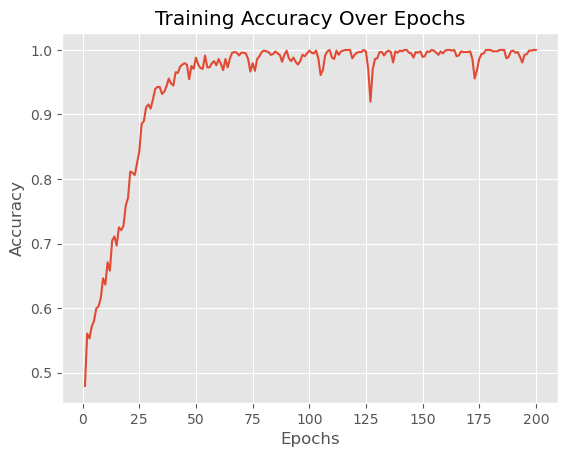

In [7]:
# Plotting the accuracy over epochs
plt.plot(range(1, num_epochs + 1), accuracies)
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

## Test Model

/tmp/ipykernel_66443/164636133.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i, j * 2 + 1].set_xticklabels(class_names, rotation=45, ha='right')


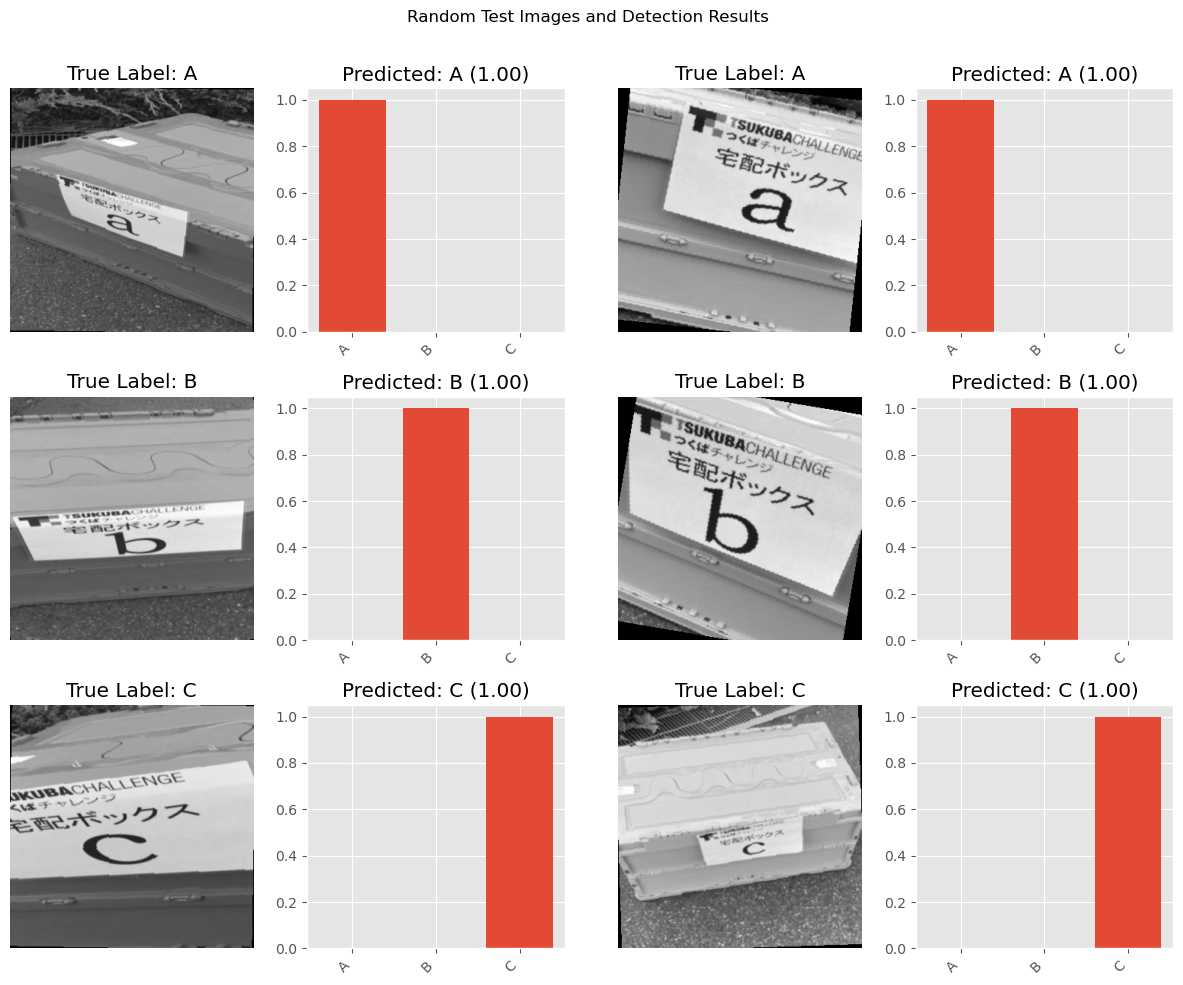

In [19]:
# Display 2 random test images from each class and their detection results
class_names = test_dataset.classes
fig, axes = plt.subplots(3, 4, figsize=(12, 10))
fig.suptitle('Random Test Images and Detection Results')

for i, class_name in enumerate(class_names):
    class_indices = [idx for idx in range(len(test_dataset)) if test_dataset[idx][1] == i]
    selected_indices = random.sample(class_indices, 2)
    
    for j, idx in enumerate(selected_indices):
        input_image, true_label = test_dataset[idx]
        input_image = input_image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(input_image)
            _, predicted = torch.max(output, 1)
            confidence = torch.softmax(output, dim=1)[0][predicted.item()].item()
        
        axes[i, j * 2].imshow(input_image.squeeze().cpu().numpy(), cmap='gray')
        axes[i, j * 2].axis('off')
        axes[i, j * 2].set_title(f'True Label: {class_name}')
        
        axes[i, j * 2 + 1].bar(class_names, torch.softmax(output, dim=1).squeeze().cpu().numpy())
        axes[i, j * 2 + 1].set_title(f'Predicted: {class_names[predicted.item()]} ({confidence:.2f})')
        axes[i, j * 2 + 1].set_xticklabels(class_names, rotation=45, ha='right')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

/tmp/ipykernel_66443/164636133.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i, j * 2 + 1].set_xticklabels(class_names, rotation=45, ha='right')


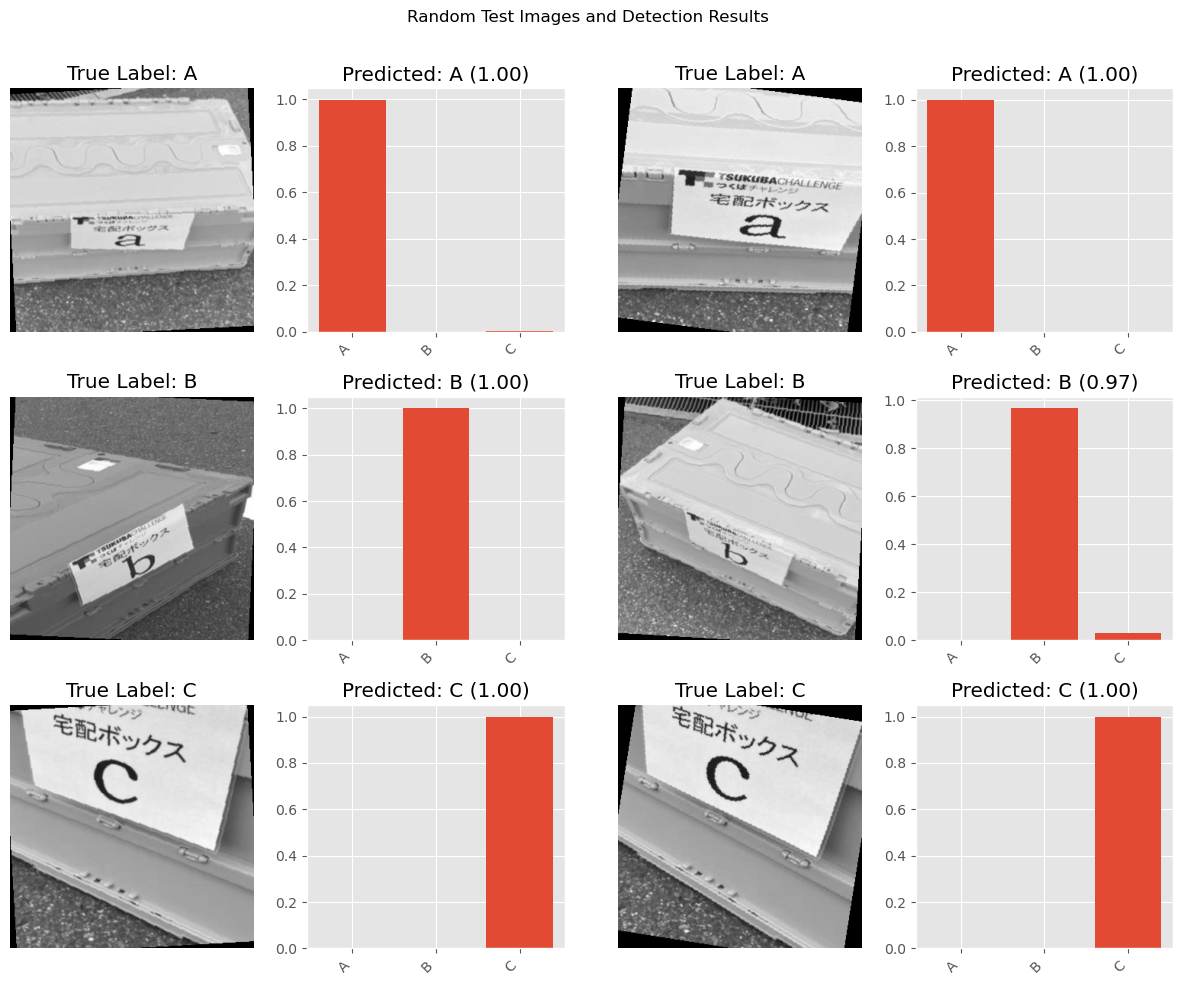

In [21]:
# Display 2 random test images from each class and their detection results
class_names = test_dataset.classes
fig, axes = plt.subplots(3, 4, figsize=(12, 10))
fig.suptitle('Random Test Images and Detection Results')

for i, class_name in enumerate(class_names):
    class_indices = [idx for idx in range(len(test_dataset)) if test_dataset[idx][1] == i]
    selected_indices = random.sample(class_indices, 2)
    
    for j, idx in enumerate(selected_indices):
        input_image, true_label = test_dataset[idx]
        input_image = input_image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(input_image)
            _, predicted = torch.max(output, 1)
            confidence = torch.softmax(output, dim=1)[0][predicted.item()].item()
        
        axes[i, j * 2].imshow(input_image.squeeze().cpu().numpy(), cmap='gray')
        axes[i, j * 2].axis('off')
        axes[i, j * 2].set_title(f'True Label: {class_name}')
        
        axes[i, j * 2 + 1].bar(class_names, torch.softmax(output, dim=1).squeeze().cpu().numpy())
        axes[i, j * 2 + 1].set_title(f'Predicted: {class_names[predicted.item()]} ({confidence:.2f})')
        axes[i, j * 2 + 1].set_xticklabels(class_names, rotation=45, ha='right')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## Save Model

In [18]:
torch.save(model, './weights/resnet.pt')
torch.save(model.state_dict(), './weights/resnet.pth')

---